In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of the sigmoid function
def sigmoid_derivative(x):
    return x * (1 - x)

# Mean Squared Error Loss
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    return np.mean(1 - (np.abs(y_true - y_pred) / y_true))

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights
        self.weights_input_hidden = np.random.uniform(-1, 1, (self.input_size, self.hidden_size))
        self.weights_hidden_hidden = np.random.uniform(-1, 1, (self.hidden_size, self.hidden_size))
        self.weights_hidden_output = np.random.uniform(-1, 1, (self.hidden_size, self.output_size))
        
        # Initialize biases
        self.bias_hidden_1 = np.zeros((1, self.hidden_size))
        self.bias_hidden_2 = np.zeros((1, self.hidden_size))
        self.bias_output = np.zeros((1, self.output_size))
        
    def feedforward(self, X):
        # Hidden layer 1
        self.hidden_1 = sigmoid(np.dot(X, self.weights_input_hidden) + self.bias_hidden_1)
        # Hidden layer 2
        self.hidden_2 = sigmoid(np.dot(self.hidden_1, self.weights_hidden_hidden) + self.bias_hidden_2)
        # Output layer
        self.output = sigmoid(np.dot(self.hidden_2, self.weights_hidden_output) + self.bias_output)
        return self.output
    
    def backpropagation(self, X, y):
        # Calculate the loss
        loss = mse_loss(y, self.output)
        
        # Calculate the output error
        error_output = self.output - y
        delta_output = error_output * sigmoid_derivative(self.output)
        
        # Calculate the error for hidden layer 2
        error_hidden_2 = np.dot(delta_output, self.weights_hidden_output.T)
        delta_hidden_2 = error_hidden_2 * sigmoid_derivative(self.hidden_2)
        
        # Calculate the error for hidden layer 1
        error_hidden_1 = np.dot(delta_hidden_2, self.weights_hidden_hidden.T)
        delta_hidden_1 = error_hidden_1 * sigmoid_derivative(self.hidden_1)
        
        # Update the weights and biases
        self.weights_hidden_output -= self.learning_rate * np.dot(self.hidden_2.T, delta_output)
        self.bias_output -= self.learning_rate * np.sum(delta_output, axis=0)
        
        self.weights_hidden_hidden -= self.learning_rate * np.dot(self.hidden_1.T, delta_hidden_2)
        self.bias_hidden_2 -= self.learning_rate * np.sum(delta_hidden_2, axis=0)
        
        self.weights_input_hidden -= self.learning_rate * np.dot(X.T, delta_hidden_1)
        self.bias_hidden_1 -= self.learning_rate * np.sum(delta_hidden_1, axis=0)
        
        return loss

# Función para preparar los datos
def prepare_data(data, window_size=2):
    X, y = [], []
    for i in range(window_size, len(data) - 1):
        X.append(data[i-window_size:i].flatten())
        y.append(data[i+1])
    X, y = np.array(X), np.array(y)
    return X, y

In [3]:
# Download historical data for Amazon (AMZN)
ticker = 'GOOGL'
data = yf.download(ticker, start='2013-01-01', end='2023-12-31', interval='1d')

# Only keep the 'Open', 'Close', 'Low', and 'High' columns
data = data[['Open', 'Close', 'Low', 'High']]

# Fill missing values using forward fill method
data.fillna(method='ffill', inplace=True)

# Ensure there are no remaining missing values
assert data.isnull().sum().sum() == 0, "There are still missing values in the data"

# Initialize the MinMaxScaler and scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Preparar datos de entrenamiento y prueba
X, y = prepare_data(data_scaled)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Inicializar la red neuronal
nn = NeuralNetwork(input_size=8, hidden_size=4, output_size=4, learning_rate=0.01)

# Entrenar la red neuronal
epochs = 10000
for epoch in range(epochs):
    output = nn.feedforward(X_train)
    loss = nn.backpropagation(X_train, y_train)
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

[*********************100%%**********************]  1 of 1 completed
C:\Users\Carlo\AppData\Local\Temp\ipykernel_18092\774509467.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Carlo\AppData\Local\Temp\ipykernel_18092\774509467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='ffill', inplace=True)


Epoch 0, Loss: 0.07784118598425761
Epoch 1000, Loss: 0.0006956640921913309
Epoch 2000, Loss: 0.0003704615095675727
Epoch 3000, Loss: 0.0002202964686157544
Epoch 4000, Loss: 0.000167261495518787
Epoch 5000, Loss: 0.00014702246233252897
Epoch 6000, Loss: 0.00013559081419927213
Epoch 7000, Loss: 0.00012731278326395625
Epoch 8000, Loss: 0.00012087623633836168
Epoch 9000, Loss: 0.00011587242604490589


In [4]:
# Realizar predicciones
predictions_train = nn.feedforward(X_train)
predictions_test = nn.feedforward(X_test)

# Transformar datos de vuelta a la escala original
def inverse_transform_all_features(scaler, data_scaled):
    data_inverse = scaler.inverse_transform(data_scaled)
    return data_inverse

train_target_original = inverse_transform_all_features(scaler, y_train)
test_target_original = inverse_transform_all_features(scaler, y_test)
predictions_train_original = inverse_transform_all_features(scaler, predictions_train)
predictions_test_original = inverse_transform_all_features(scaler, predictions_test)

# Asegurarse de que los índices coinciden
train_index = data.index[2:train_size + 2]
test_index = data.index[train_size + 2: train_size + 2 + len(y_test)]

# Calculate accuracy
accuracy = calculate_accuracy(test_target_original, predictions_test_original)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 97.69%


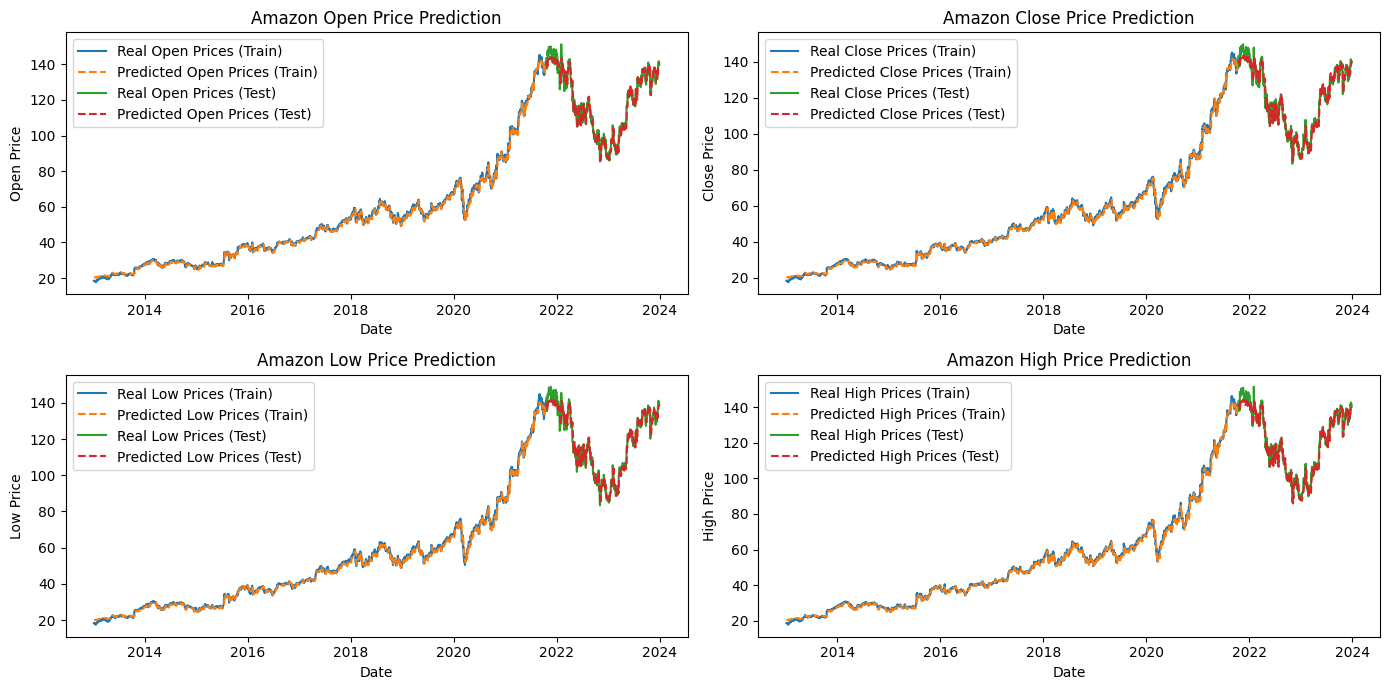

In [5]:
# Graficar los resultados
plt.figure(figsize=(14, 7))

# Gráfica de entrenamiento y prueba para cada característica
for i, col in enumerate(['Open', 'Close', 'Low', 'High']):
    plt.subplot(2, 2, i+1)
    plt.plot(train_index, train_target_original[:, i], label=f'Real {col} Prices (Train)')
    plt.plot(train_index, predictions_train_original[:, i], linestyle='--', label=f'Predicted {col} Prices (Train)')
    plt.plot(test_index, test_target_original[:, i], label=f'Real {col} Prices (Test)')
    plt.plot(test_index, predictions_test_original[:, i], linestyle='--', label=f'Predicted {col} Prices (Test)')
    plt.xlabel('Date')
    plt.ylabel(f'{col} Price')
    plt.title(f'Amazon {col} Price Prediction')
    plt.legend()

plt.tight_layout()
plt.show()

With Amazon: Accuracy: 97.92%


With Google: Accuracy: 97.69%